# Cobining Thresholds
In this interactive jupyter notebook you can explore the effect of the threshold limits and kernel sizes for different gradients and see their combined effect on an image in order to detect lane lines.

## Instructions:
* Run all cells.
* Adjust min, max and ksize for the four different gradients.
* Re-run the last cell to see their combined effect.

In [24]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from ipywidgets import widgets

from ImageProcessing import perspective_transform, inv_perspective_transform
from ImageThresholding import binarize_img, normalize_img, grad_x, grad_y, mag_grad, dir_grad
from ImageThresholding import and_images


%matplotlib inline

In [39]:
def show(*images,title=None):
    f, axes = plt.subplots(1,len(images), squeeze=False)
    f.set_size_inches((6 * len(images),8))
    if title and len(images)==1 and type(title) == str:
        title = [title]
    for i in range(len(images)):
        img = images[i]
        ax = axes[0][i]
        if title is not None:
            assert len(title) == len(images)
            t = title[i]
            ax.text(0.5, 1.05, t, transform=ax.transAxes, fontsize=14, verticalalignment='bottom', horizontalalignment='center')
        if len(img.shape) == 3:
            ax.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
        else:
            ax.imshow(img, cmap="gray")


def load_and_preprocess(file_name):
    orig_img = cv2.imread(file_name)
    warped_img, M_inv = perspective_transform(orig_img)
    return orig_img,warped_img,bgr2hls(warped_img)
    
    
def split_hls(img):
    hls_img = cv2.cvtColor(img,cv2.COLOR_BGR2HLS)
    return hls_img[:,:,0], hls_img[:,:,1], hls_img[:,:,2]


def join_hls(h,l,s):
    return hls2bgr(np.stack((h,l,s),axis=2))


def plot_hls(img):
    f, axes = plt.subplots(1,3)
    f.set_size_inches((24,8))
    for ch,ax in zip(split_hls(img),axes):
        ax.imshow(ch,cmap="gray")
        

def hls_mask(img, min_h, max_h, min_l, max_l, min_s, max_s):
    hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
    return cv2.inRange(hls, np.array([min_h,min_l,min_s]), np.array([max_h,max_l,max_s]))


def apply_mask(img, mask):
    return cv2.bitwise_and(img,img,mask=mask)

                
def mask_hls(img, min_h, max_h, min_l, max_l, min_s, max_s):
    mask = hls_mask(img, min_h, max_h, min_l, max_l, min_s, max_s)
    return apply_mask(img, hls_mask)
    

def bgr2hls(img):
    return cv2.cvtColor(img, cv2.COLOR_BGR2HLS)


def hls2bgr(img):
    return cv2.cvtColor(img, cv2.COLOR_HLS2BGR)


def equalize(img):
    h,l,s = split_hls(img)
    l = cv2.equalizeHist(l)
    return join_hls(h,l,s)


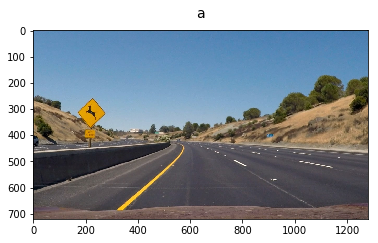

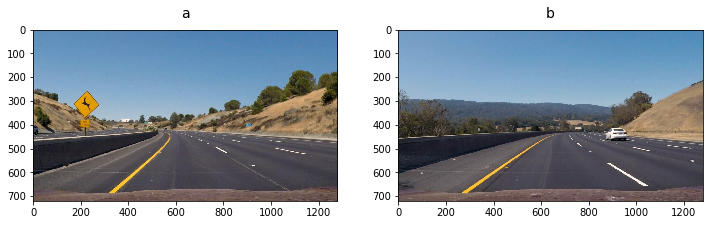

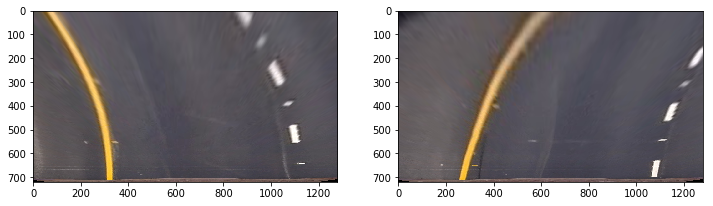

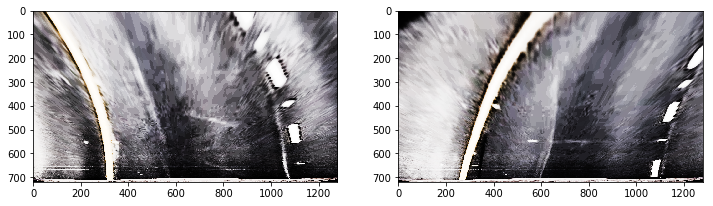

In [40]:
import Common
orig_img_a, warped_img_a, warped_img_a_hls = load_and_preprocess("test_images/test2.jpg")
orig_img_b, warped_img_b, warped_img_b_hls = load_and_preprocess("test_images/test3.jpg")
show(orig_img_a, title="a")
show(orig_img_a, orig_img_b, title=["a", "b"])
#plot_hls(warped_img_a)
show(warped_img_a, warped_img_b)
show(equalize(warped_img_a), equalize(warped_img_b))
#plot_hls(warped_img_b)


<function __main__.plt_yellow>

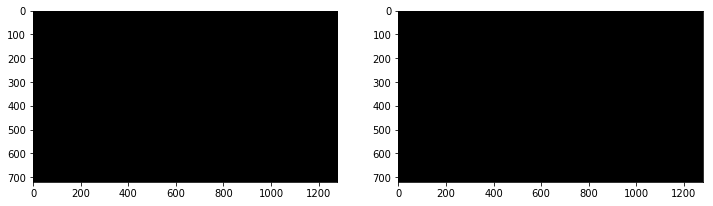

In [4]:
def enhance_white_yellow(img, min_l=116, min_s=80):
    yello = hls_mask(img, 13, 24, min_l, 207, min_s, 255)
    white = hls_mask(img, 0, 180, 206, 255, 0, 255)
    mask = cv2.bitwise_or(yello, white)
    return apply_mask(img, mask)


def plt_yellow(min_h, max_h, min_l, max_l, min_s, max_s):
    hls = cv2.cvtColor(warped_img_a, cv2.COLOR_BGR2HLS)
    a = cv2.inRange(hls, np.array([min_h,min_l,min_s]), np.array([max_h,max_l,max_s]))
    hls = cv2.cvtColor(warped_img_b, cv2.COLOR_BGR2HLS)
    b = cv2.inRange(hls, np.array([min_h,min_l,min_s]), np.array([max_h,max_l,max_s]))
    show(a,b)
    
widgets.interact(plt_yellow, min_h=(0,180,1), max_h=(0,180,1), min_l=(0,255,1), max_l=(0,255,1), min_s=(0,255,1), max_s=(0,255,1))      

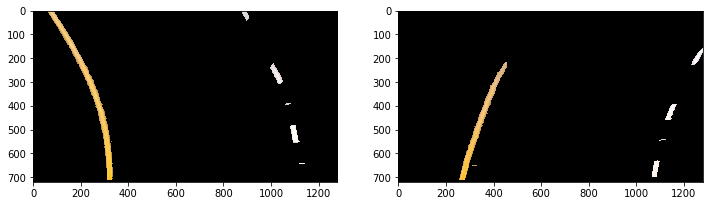

In [5]:
img_a = None
img_b = None
img_a_hls = None
img_b_hls = None

def plt_enhance_yellow(min_s):
    global img_a, img_b,img_a_hls,img_b_hls
    img_a = enhance_white_yellow(warped_img_a,min_s=min_s)
    img_b = enhance_white_yellow(warped_img_b,min_s=min_s)
    show(img_a,img_b)
    img_a_hls = bgr2hls(img_a)
    img_b_hls = bgr2hls(img_b)
    
widgets.interact(plt_enhance_yellow, min_s=(64,128,1))

<function __main__.plt_white>

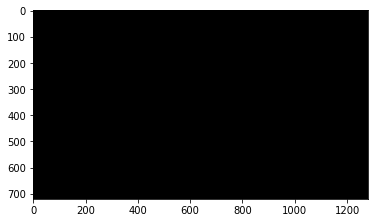

In [6]:
def plt_white(min_h, max_h, min_l, max_l, min_s, max_s):
    hls = cv2.cvtColor(warped_img_b, cv2.COLOR_BGR2HLS)
    result = cv2.inRange(hls, np.array([min_h,min_l,min_s]), np.array([max_h,max_l,max_s]))
    show(result)
    
widgets.interact(plt_white, min_h=(0,180,1), max_h=(0,180,1), min_l=(0,255,1), max_l=(0,255,1), min_s=(0,255,1), max_s=(0,255,1))      

<function __main__.plt_gradx>

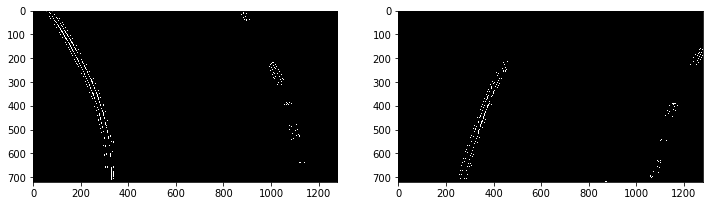

In [41]:
def plt_gradx(min, delta, ksize,ch,inv):
    a = grad_x(img_a_hls, min, min+delta, ksize=ksize,ch=ch)
    b = grad_x(img_b_hls, min, min+delta, ksize=ksize,ch=ch)
    if inv==1:
        a = cv2.bitwise_not(a)
        b = cv2.bitwise_not(b)
    show(a,b)
                                                 
widgets.interact(plt_gradx, min=(0,32,1), delta=(0,32,1), ksize=(3,31,2),ch=(0,2,1),inv=(0,1,1))      

<function __main__.plt_grady>

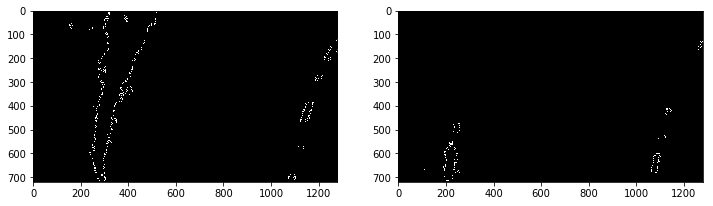

In [8]:
def plt_grady(min, delta, ksize,ch,inv):
    a = grad_y(img_a, min, min+delta, ksize=ksize,ch=ch)
    b = grad_y(img_b, min, min+delta, ksize=ksize,ch=ch)
    if inv == 1:
        a = cv2.bitwise_not(a)
        b = cv2.bitwise_not(b)

    show(a,b)
    
widgets.interact(plt_grady, min=(0,64,1), delta=(0,64,1), ksize=(3,31,2), ch=(0,2,1),inv=(0,1,1))


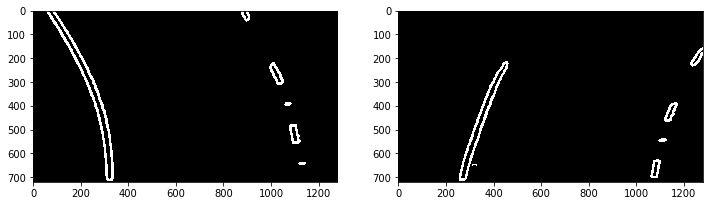

In [15]:
def plt_mag_binary(min, max, ksize,ch,inv):
    a = mag_grad(img_a_hls, min, max, ksize=ksize, ch=ch)
    b = mag_grad(img_b_hls, min, max, ksize=ksize, ch=ch)
    if inv==1:
        a = cv2.bitwise_not(a)
        b = cv2.bitwise_not(b)
    show(a,b)
                             
widgets.interact(plt_mag_binary, min=(0,255,1), max=(0,255,1), ksize=(3,31,2),ch=(0,2,1),inv=(0,1,1))

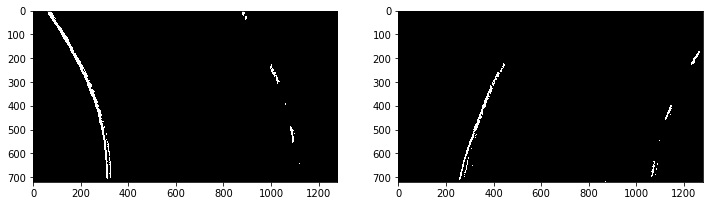

In [19]:
%matplotlib inline
def plt_dir_binary(min, delta, ksize,ch):
    a = dir_grad(img_a_hls, (min-0.5*delta)*np.pi, (min+0.5*delta)*np.pi, ksize,ch=ch).astype(np.uint8)
    a1 = mag_grad(img_a_hls, 1, 255, ch=ch)
    b = dir_grad(img_b_hls, (min-0.5*delta)*np.pi, (min+0.5*delta)*np.pi, ksize,ch=ch).astype(np.uint8)
    b1 = mag_grad(img_b_hls, 1, 255, ch=ch)
    a = cv2.bitwise_and(a,a1)
    b = cv2.bitwise_and(b,b1)
    show(a,b)
    #ca = enhance_lines(img_a,min,delta,ksize,ch)
    #cb = enhance_lines(img_b,min,delta,ksize,ch)
    #show(ca,cb)
    
widgets.interact(plt_dir_binary, min=(0,2,1/256), delta=(0,1.0,1.0/256), ksize=(3,31,2),ch=(0,2,1))

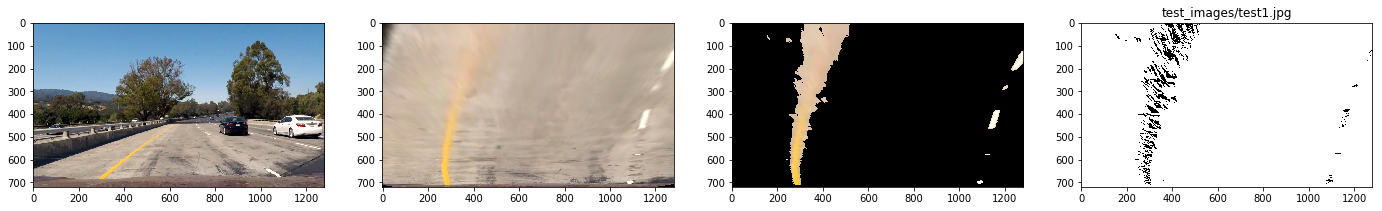

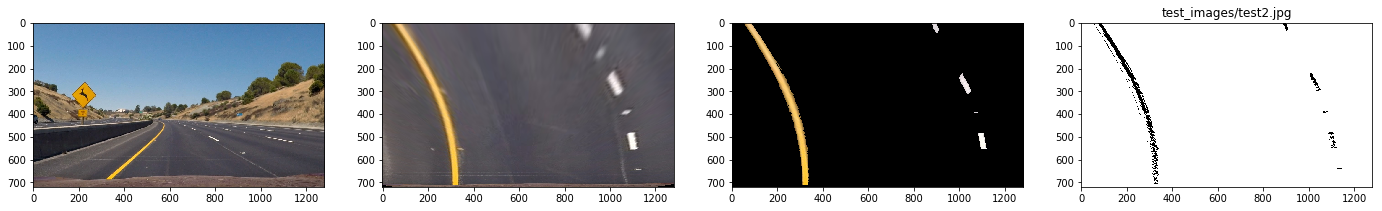

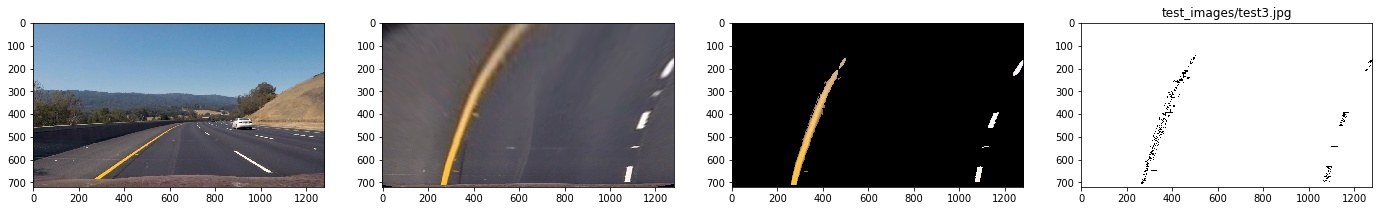

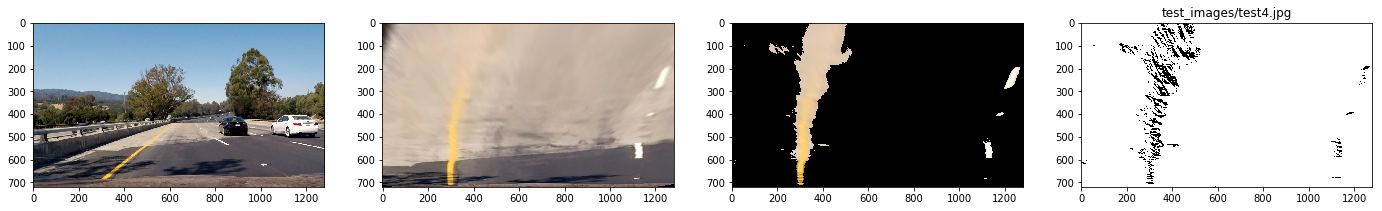

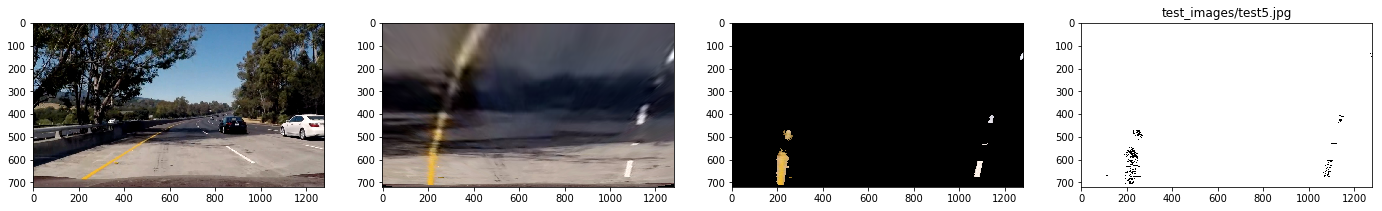

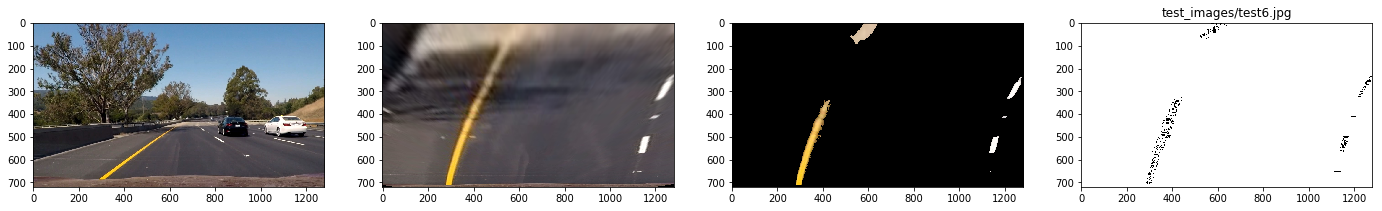

In [11]:
def enhance_lines(img):
    wy = enhance_white_yellow(img,min_l=92, min_s=95)
    a = bgr2hls(wy)
    a = dir_grad(a, -1.50*np.pi, (+0.25)*np.pi, ksize=5, ch=2).astype(np.uint8)
    return a,wy

import glob
for f in glob.glob("test_images/test*.jpg"):
    orig_img, warped_img, warped_img_a_hls = load_and_preprocess(f)
    enhanced_img,wy_img = enhance_lines(warped_img)
    show(orig_img,warped_img,wy_img,enhanced_img,title=f)


In [12]:
# Apply each of the thresholding functions
gradx = abs_sobel_thresh(img, orient='x', sobel_kernel=ksize_gradx, thresh=(min_gradx, max_gradx))
grady = abs_sobel_thresh(img, orient='y', sobel_kernel=ksize_grady, thresh=(min_grady, max_grady))
mag_binary = mag_thresh(img, sobel_kernel=ksize_mag, mag_thresh=(min_mag, max_mag))
dir_binary = dir_threshold(img, sobel_kernel=ksize_dir, thresh=(min_dir, max_dir))

combined = np.zeros_like(dir_binary)
combined[((gradx == 1) | (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1

f, ax = plt.subplots(1,1)
ax.imshow(combined,cmap='gray')

NameError: name 'abs_sobel_thresh' is not defined

In [ ]:
histogram = np.sum(combined[int(combined.shape[0]/2):,:], axis=0)
plt.plot(histogram)

In [ ]:
from scipy.signal import find_peaks_cwt
peaks = find_peaks_cwt(histogram, np.arange(4.0,128.0))
print(peaks)

In [ ]:
def sliding_window(img, start_x):
    h,w = img.shape
    delta_y = 16
    delta_x = 64
    result = []
    y = h - delta_y
    x = start_x
    x1 = int(max(0,start_x - delta_x / 2))
    x2 = x1 + delta_x
    while y >= 0:
        histogram = np.sum(img[y:y+delta_y, x1:x2], axis=0)
        peaks = find_peaks_cwt(histogram, np.arange(delta_x/2,delta_x))
        if len(peaks):
            x = peaks[0] + x1
            result.append((x,y))
        y -= int(delta_y / 2)
        
    return np.array(result)
            
left = sliding_window(combined, 42)
right = sliding_window(combined, 218)
plt.imshow(combined, cmap="gray")
plt.plot(left[:,0], left[:,1], 'ro')
plt.plot(right[:,0], right[:,1], 'go')


In [ ]:
def fit_quadratic(array):
    return np.poly1d(np.polyfit(array[:,1],array[:,0],2))

def calc_radius(array):
    z = fit_quadratic